# Transfer Learning & Fine Tuning 

## What you'll learn in this class 🧐🧐

An interesting feature of deep learning models is that once it's been trained on some general task, it is possible to channel its predictive power for more specific tasks, this is called _Transfer Learning_.

The principle is simple, instead of building a neural network architecture from scratch, we will use pre-made and pre-trained architectures. This technique allows us to achieve _state of the art_ performance results. 

This course therefore aims to show how to perform _Transfer Learning_ with pytorch. We will use this for image recognition on flower types contained in a *flower_photos* folder.

## Loading dataset & preprocessing. 

### Downloading images from paths

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import os
import requests
import zipfile
from pathlib import Path

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


We will use the *get_file* method of the *torch.keras.utils* module to download public data contained in Google Cloud Storage that we will then store in a *flower_photos* folder.

In [2]:
# Path to your .tgz file
output_path = "flower_photos.tgz"
extract_dir = "flower_photos"  # Folder where files will be extracted

# Download and extract the dataset
url = 'https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/flower_photos.zip'
def load_and_extract_files(url,output_path,extract_dir):
    # Download the dataset
    if not os.path.exists(output_path):
        response = requests.get(url, stream=True)
        with open(output_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download complete.")

    # Extract the dataset
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(output_path, "r") as zip_ref:
            zip_ref.extractall(f"./{extract_dir}")
        print("Extraction complete.")

load_and_extract_files(url,output_path,extract_dir)

Download complete.
Extraction complete.


In [3]:
data_root = Path("flower_photos/train")
for item in data_root.iterdir():
  print(item)

flower_photos/train/daisy
flower_photos/train/rose
flower_photos/train/tulip
flower_photos/train/dandelion
flower_photos/train/sunflower


We will now create an `ImageDataGenerator` object in order to use data augmentation on our flower images.

In [4]:
# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Now that we have set up the transformations we wish to apply to our images on the fly, we will create two objects that will be able to produce images on demand from the train set and valdiation set respectively.

We are able to set up the target image size and the batch size during this step too!

In [5]:
# Load datasets with ImageFolder
dataset = datasets.ImageFolder(root=data_root, transform=transform)

# Get class names
class_names = dataset.classes

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Let's visualize a batch of images from the train set.

Label : daisy


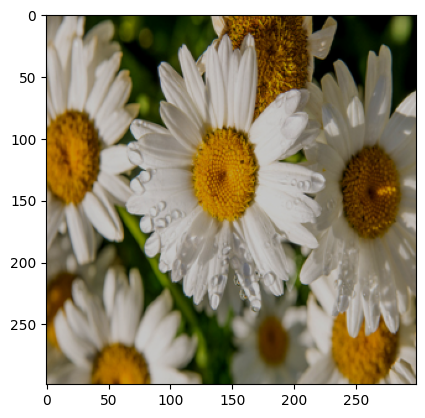

Label : tulip


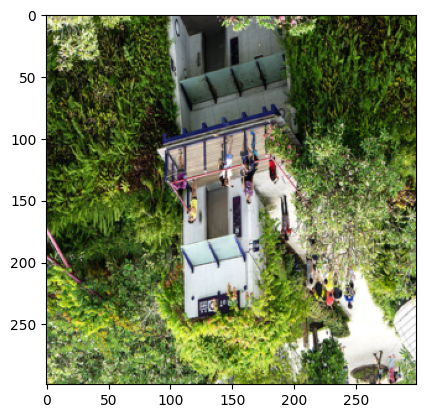

Label : rose


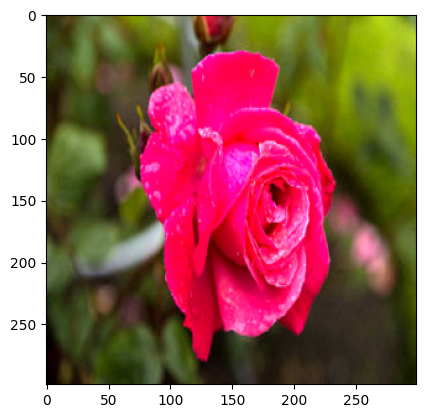

Label : rose


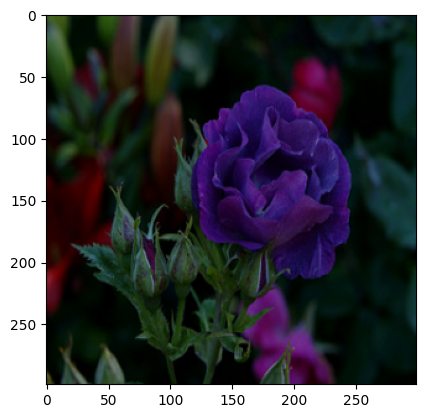

Label : tulip


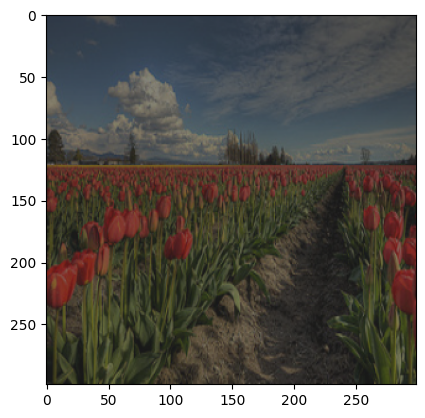

Label : sunflower


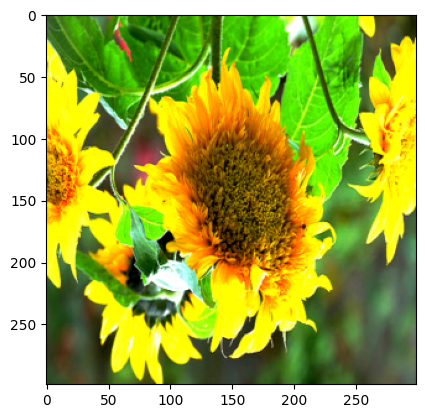

Label : sunflower


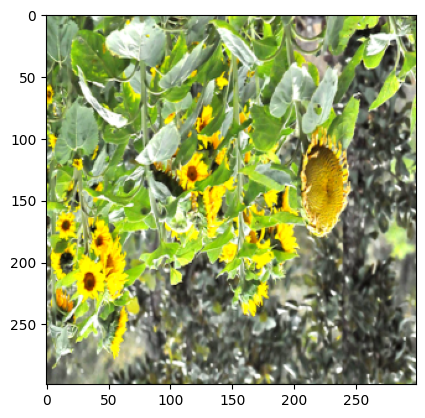

Label : rose


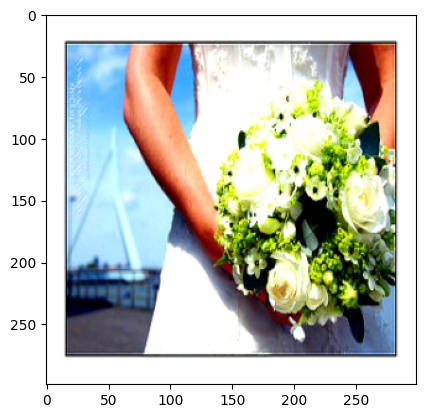

Label : daisy


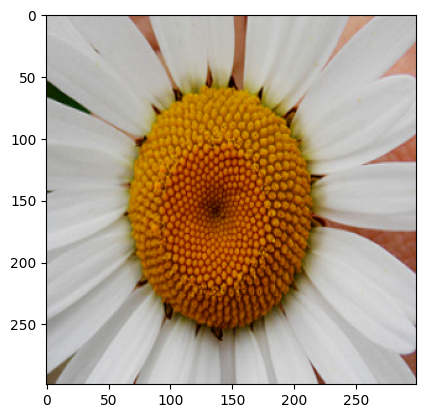

Label : rose


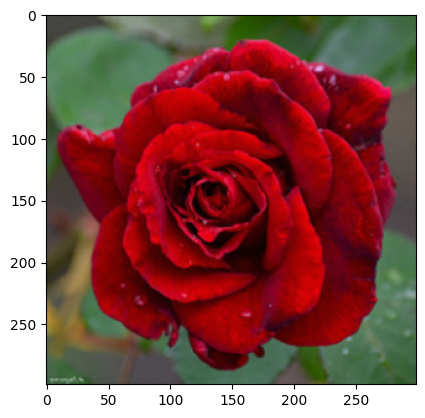

In [6]:
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path

imgs, labels = next(iter(train_loader))
for i, (img, label) in enumerate(zip(imgs, labels)):
  true_label_name = class_names[label]
  print("Label :", true_label_name)
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.show()
  if i==9: break

We are now all set, and ready to embark on our transfer learning journey!

## Transfer Learning 

### Importing a pre-trained model 

Now that our images are pre-processed, we can move on to the modeling part. We will use an already existing architecture: MobileNet and use it to classify our flowers. Here is how we can proceed:

In [7]:
# Load a pre-trained model (Inception v3)
model = models.inception_v3(weights="IMAGENET1K_V1")


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/qxzjy/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100.0%


Here we have imported the architecture to which we have specified not to take the last output layer. Indeed, this layer will be adapted to our need for flower classification. This model has been trained on a much larger number of different images from the <a href="http://www.image-net.org/">imagenet </a> dataset. 

Let's have a quick look at the architecture of our model:

In [8]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [9]:
from torchinfo import summary

# Print model summary
summary(model, input_size=(1, 3, 299, 299))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 1000]                 3,326,696
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         128
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [1, 80, 73, 73]           5,

Now we have to freeze our model so that only the custom layers will train.

In [10]:
# Freeze the feature extraction layers
for param in model.parameters():
    param.requires_grad = False

This prevents us from training our entire model. Let us now add the last layer which interests us for our problem 

### Adapting the model to the dataset

When we imported our model, we removed the last layer to be able to adapt the model to our situation. So now let's use the next cell of code to add our last layer. 

We will use a `GlobalMaxPooling2D` layer which will output the most significant pixels of the image, and a last `Dense` layer which will take the number of classes of our dataset and a `softmax` activation function which will output probabilities for each of the predictions. 

In [11]:
# Modify the final classification layer to match the number of classes
num_classes = len(train_dataset.dataset.classes)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, num_classes),
    nn.Softmax(dim=1)
)
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Let's prepare our cost function, our optimization and a learning rate schedule to improve our prediction results and minimize our cost function. 

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # Move loss function to MPS

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


Now let's train our model.

We start by looking at the model's output:

In [13]:
input, label = next(iter(train_loader))
logit, aux_logit = model(input.to(device))
logit

tensor([[0.1838, 0.2595, 0.2273, 0.1245, 0.2049],
        [0.2283, 0.2140, 0.2466, 0.0883, 0.2228],
        [0.1266, 0.4090, 0.1790, 0.1143, 0.1711],
        [0.1711, 0.3082, 0.1973, 0.1764, 0.1470],
        [0.2088, 0.2001, 0.2173, 0.1515, 0.2223],
        [0.2138, 0.1786, 0.2022, 0.2094, 0.1960],
        [0.2527, 0.1829, 0.1524, 0.2364, 0.1756],
        [0.1028, 0.2588, 0.2572, 0.1904, 0.1908],
        [0.1389, 0.1632, 0.2034, 0.0846, 0.4098],
        [0.1643, 0.1524, 0.3107, 0.1876, 0.1850],
        [0.1902, 0.2783, 0.1575, 0.1003, 0.2737],
        [0.1760, 0.2344, 0.2494, 0.1722, 0.1680],
        [0.3015, 0.1647, 0.1632, 0.1155, 0.2551],
        [0.1798, 0.2197, 0.1924, 0.1607, 0.2475],
        [0.1601, 0.2342, 0.2464, 0.1787, 0.1807],
        [0.1570, 0.2157, 0.2304, 0.1271, 0.2698],
        [0.3511, 0.1893, 0.2128, 0.1168, 0.1300],
        [0.1907, 0.2451, 0.1806, 0.1452, 0.2383],
        [0.2604, 0.2835, 0.1907, 0.1018, 0.1636],
        [0.1804, 0.1625, 0.2900, 0.1452, 0.2219],


As you can see there are two different outputs, `logits`, and `aux_logits`. Let's extract the first one as this is the one we'll need for training the model.

In [14]:
aux_logit

tensor([[ 0.1016, -2.0268,  0.4248,  ...,  0.6726,  0.2400,  1.1225],
        [-0.9418, -2.3888,  1.6864,  ..., -1.9609,  0.4961,  1.2603],
        [ 0.8656,  1.8516,  1.0637,  ...,  0.3676,  1.9538, -1.0796],
        ...,
        [-0.0832, -0.7123,  0.4899,  ..., -1.0713, -0.4636, -1.0319],
        [-0.4561, -0.2622, -2.8969,  ..., -1.7276, -0.8429, -1.0858],
        [ 4.5589,  0.7172,  1.3432,  ..., -0.1985,  3.4495, -0.2162]],
       device='mps:0')

In [15]:
# Training function for a PyTorch model
def train(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    """
    Function to train a PyTorch model and evaluate it on a validation set.

    Parameters:
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - criterion: Loss function (e.g., CrossEntropyLoss for classification).
    - optimizer: Optimization algorithm (e.g., Adam, SGD).
    - epochs: Number of training epochs (default = 50).

    Returns:
    - history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store loss and accuracy values for each epoch
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    # Loop through the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize loss and correct predictions
        
        # Training loop - iterate through batches in the training set
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            logit, aux_logit = model(inputs)  # Forward pass: Get predictions
            loss = criterion(logit, labels)  # Compute loss
            loss.backward()  # Backpropagation: Compute gradients
            optimizer.step()  # Update model parameters using optimizer
            
            total_loss += loss.item()  # Accumulate total loss
            correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for the training set
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase (no gradient calculation needed)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                logit = model(inputs)  # Forward pass
                _, preds = torch.max(logit, 1) # extract predictions
                loss = criterion(logit, labels.data)  # Compute validation loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for the validation set
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)
        
        # Store training and validation metrics for analysis
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        # Print progress after each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history  # Return training history

# Train the model and store the training history
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch [1/5], Loss: 1.4631, Acc: 0.4880, Val Loss: 1.3333, Val Acc: 0.6517
Epoch [2/5], Loss: 1.2734, Acc: 0.7253, Val Loss: 1.2325, Val Acc: 0.7779
Epoch [3/5], Loss: 1.2132, Acc: 0.7690, Val Loss: 1.1979, Val Acc: 0.7743
Epoch [4/5], Loss: 1.1744, Acc: 0.7903, Val Loss: 1.1587, Val Acc: 0.8070
Epoch [5/5], Loss: 1.1716, Acc: 0.7825, Val Loss: 1.1518, Val Acc: 0.8010


In [16]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [17]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Our results are not bad already! We can however try to continue training our model but this time by releasing some layers. This is called _fine tuning_. So we're going to unlock the last 20 layers of the model. 

In [ ]:
model = models.inception_v3(weights="IMAGENET1K_V1")
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Unfreeze last 30 layers for fine-tuning
fine_tune_at = len(list(model.children())) - 30
for param in list(model.parameters())[:fine_tune_at]:
    param.requires_grad = False

In [26]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [28]:
from torchinfo import summary

# Print model summary
summary(model, input_size=(1, 3, 299, 299))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 5]                    3,326,696
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         (864)
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         (64)
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         (9,216)
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         (64)
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         (18,432)
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         (128)
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [1, 80, 73, 73] 

In [29]:
input, label = next(iter(train_loader))
model = model.to(device)
logit, aux_logit = model(input.to(device))
logit

tensor([[ 0.4226,  0.4451, -0.3319,  0.5972, -0.1243],
        [ 0.4107, -0.1239, -0.5948,  0.1900, -0.4974],
        [-0.1361,  0.0550, -0.0538,  0.4414, -0.1629],
        [-0.0756, -0.2099, -0.4996,  0.9157,  0.1318],
        [ 0.2169, -0.2556, -0.8939,  0.2886, -0.1550],
        [ 0.5645,  0.2634, -0.1342,  0.4372,  0.0171],
        [ 0.0620,  0.0888, -0.1825,  0.2617,  0.4481],
        [ 0.3373,  0.5902, -0.4371,  0.2678,  0.1982],
        [ 0.2534, -0.2014, -0.4537,  0.5715,  0.1689],
        [ 0.3294, -0.1286, -0.0248,  0.3384,  0.2754],
        [-0.3673, -0.3019, -0.5648,  0.0446,  0.0716],
        [ 0.4079, -0.0558,  0.2843,  0.3659,  0.1661],
        [ 0.3184, -0.2569, -0.3603,  0.1692,  0.4283],
        [ 0.2448, -0.3978, -0.2050,  0.1041, -0.0532],
        [ 0.1725,  0.0158, -0.3671,  0.4219, -0.2022],
        [-0.0914, -0.2649,  0.4289, -0.1568, -0.1999],
        [ 0.7489, -0.4891, -0.0382,  0.0810,  0.0955],
        [ 0.1038,  0.0145, -0.3457,  0.1862,  0.1812],
        [ 

Let's try to train the model again. 

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate
history_finetune = train(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch [1/5], Loss: 1.3031, Acc: 0.5375, Val Loss: 1.0055, Val Acc: 0.7694
Epoch [2/5], Loss: 0.9077, Acc: 0.7711, Val Loss: 0.7668, Val Acc: 0.8119
Epoch [3/5], Loss: 0.7186, Acc: 0.8169, Val Loss: 0.6369, Val Acc: 0.8410
Epoch [4/5], Loss: 0.6227, Acc: 0.8413, Val Loss: 0.5731, Val Acc: 0.8422
Epoch [5/5], Loss: 0.5418, Acc: 0.8502, Val Loss: 0.5190, Val Acc: 0.8495


## Visualize the learning process

To visualize the learning process, you will use the `history` attribute from your model object.

In [31]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_finetune["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_finetune["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [32]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_finetune["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_finetune["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

## Resources 📚📚

* [Transfer Learning using pre-trained ConvNets](https://www.pytorch.org/beta/tutorials/images/transfer_learning)
* [History](https://www.pytorch.org/api_docs/python/torch/keras/callbacks/History)